# First load the data

In [1]:
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
from scipy.stats.stats import pearsonr 
import math


gameStats = pd.read_csv('gameStats_v2.csv')
gameStats.drop('Unnamed: 0', axis=1, inplace=True)

aggregate_stats=['defense_int_tds','defense_misc_tds','defense_sk','defense_frec_tds',\
               'defense_frec_tds','defense_puntblk','defense_fgblk',\
               'defense_xpblk','defense_int','defense_frec','defense_safe',\
               'defense_ffum','defense_pass_def','defense_int_yds',\
               'defense_tkl_loss','defense_tkl_loss_yds']

/Users/richardknoche/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/richardknoche/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


# Calculate the Fantasy Points for each row in our data frame

In [3]:
#Add fantasy points column
point_dict={
    'passing_yds': 0.04,
    'passing_tds': 6,
    'passing_int': -2,
    'passing_twoptm': 2,
    'rushing_yds': 0.1,
    'rushing_tds': 6,
    'rushing_twoptm': 2,
    'receiving_yds': 0.1,
    'receiving_rec': 1,
    'receiving_tds': 6,
    'receiving_twoptm': 2,
    'kickret_tds': 6,
    'puntret_tds': 6,
    'fumbles_rec_tds': 6,
    'fumbles_lost': -2,
    'defense_int_tds': 6,
    'defense_frec_tds': 6,
    'defense_misc_tds': 6,
    'defense_sk': 1,
    'defense_puntblk': 2,
    'defense_fgblk': 2,
    'defense_xpblk': 2,
    'defense_int': 2,
    'defense_frec': 2,
    'defense_safe': 2,
    #No 2 pnt return data
    #No 1 pnt safety data
    #Need to figure out how to deal with defense points allowed and yds allowed
    'kicking_xpmade': 1,
    'kicking_fgmissed': -1,
    #Need to handle kicking yardage 
}

def CalcFantasyPoints(row):
    points = 0
    for stat in point_dict:
        points += row[stat] * point_dict[stat]
    return points

gameStats['FantasyPoints']=gameStats.apply(CalcFantasyPoints,axis=1)

# Find the Season each game was played in

In [4]:
gameStats['Season']=gameStats.apply(lambda row: np.floor( (row['Week']-1)/17 ) + 1 ,axis=1)

# Calculate a player's Fantasy Points in the last season, and two seasons ago

In [6]:
#Note: PriorSeasonPoints will be nonsense for 2009 
#Note: TwoPriorSeasonPoints will be nonsense for 2009 and 2010

def FindSeasonScore(row,seasons_prior):

    player=row['Player']
    player_id=row['PlayerID']
    season = row['Season']-seasons_prior
    tot_points = gameStats[(gameStats['Player']==player) & (gameStats['PlayerID']==player_id) & \
              (gameStats['Season']==season)]['FantasyPoints'].sum()
        
    return tot_points

gameStats['PriorSeasonPoints']=gameStats.apply(FindSeasonScore,args=[1] ,axis=1)
gameStats['TwoPriorSeasonPoints']=gameStats.apply(FindSeasonScore,args=[2] ,axis=1)

In [7]:
gameStats.to_csv('gameStats_withFeats.csv')

# Calculate the player's average stats over the last N weeks (including fantasy points)

In [8]:
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

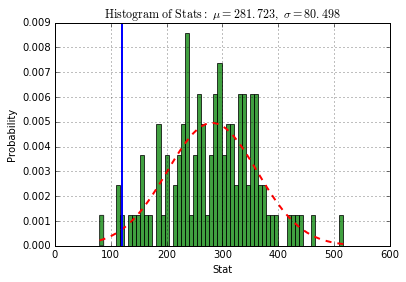

In [9]:
#Find outlier games where players were injured before or during the game
#Turns out even players like Tom Brady can have legitmate -3sigma games
#Will have to just use a cut on all stats != 0 instead of trying to identify outlier games

test=gameStats[gameStats['Player']=='Tom Brady']
tarHist=np.hstack(test['passing_yds'].tolist())

# best fit of data
(mu, sigma) = norm.fit(tarHist)

# determine cutoff for "outlier"
outlier_min = mu-2*sigma

# the histogram of the data
n, bins, patches = plt.hist(tarHist, 60, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.axvline(linewidth=2, color='b',x=outlier_min)

#plot
plt.xlabel('Stat')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ Stats:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)

plt.show()

In [10]:
gameStats.columns

Index([u'Player', u'PlayerID', u'Position', u'Inferred Position', u'Week',
       u'Team', u'At Home', u'Opponent', u'Outcome', u'Team Players',
       u'Opponent Players', u'Player Benched', u'passing_yds', u'passing_tds',
       u'passing_twoptm', u'passing_int', u'rushing_yds', u'rushing_tds',
       u'rushing_twoptm', u'receiving_yds', u'receiving_rec', u'receiving_tds',
       u'receiving_twoptm', u'kickret_tds', u'puntret_tds', u'fumbles_rec_tds',
       u'fumbles_lost', u'passing_att', u'passing_cmp', u'passing_incmp',
       u'passing_cmp_air_yds', u'passing_sk', u'passing_sk_yds',
       u'passing_twopta', u'receiving_tar', u'receiving_twopta',
       u'receiving_yac_yds', u'rushing_att', u'rushing_twopta', u'kicking_xpa',
       u'kicking_xpmade', u'kicking_xpmissed', u'kicking_fga', u'kicking_fgm',
       u'kicking_fgmissed', u'kicking_fgm_yds', u'kicking_fgmissed_yds',
       u'kicking_all_yds', u'defense_int_tds', u'defense_misc_tds',
       u'defense_sk', u'defense_frec_t

In [11]:
#First mark games where the player had no stats, since this isn't a good example of their "average"
gameStats['NoStats'] = gameStats.ix[:,'passing_yds':'defense_points_allowed'].sum(axis=1) == 0

In [21]:
def FindPlayerAverage(row,num_weeks,opp=None):
    #Finds average stats of a player over the last num_weeks
    #Can specify and opponent to determine average against a specific opponent
    #Ignored weeks where the player had zero stats (assuming they didn't play)
    player=row['Player']
    player_id=row['PlayerID']
    current_week=row['Week']
    
    start_week = current_week - num_weeks

    #Only use games against the opponent
    if opp:
        means = gameStats[(gameStats['Player']==player) & \
                  (gameStats['PlayerID']==player_id) & \
                  (gameStats['Week']>=start_week) & \
                  (gameStats['NoStats']==False) & \
                  (gameStats['Opponent']==opp) & \
                  (gameStats['Week']<current_week)].ix[:,'passing_yds':'FantasyPoints'].mean()

    else:
        means = gameStats[(gameStats['Player']==player) & \
                  (gameStats['PlayerID']==player_id) & \
                  (gameStats['Week']>=start_week) & \
                  (gameStats['NoStats']==False) & \
                  (gameStats['Week']<current_week)].ix[:,'passing_yds':'FantasyPoints'].mean()
        
    return means

In [22]:
#8 week average (0.5 season) - this will be nonsense for first half of 2009
import time
t0=time.time()
num_weeks=8
avgStats = gameStats.apply(FindPlayerAverage,args=[num_weeks],axis=1)
avgStats.columns = [('%s_%dweekAvg' % (column,num_weeks)) for column in avgStats.columns]
gameStats = pd.concat([gameStats,avgStats],axis=1)
t1=time.time()
print t1-t0

1156.43019605


In [23]:
#17 week average (1 season) - this will be nonsense for 2009
num_weeks=17
avgStats = gameStats.apply(FindPlayerAverage,args=[num_weeks],axis=1)
avgStats.columns = [('%s_%dweekAvg' % (column,num_weeks)) for column in avgStats.columns]
gameStats = pd.concat([gameStats,avgStats],axis=1)

In [24]:
#34 week average (2 season) - this will be nonsense for 2009 and 2010
num_weeks=34
avgStats = gameStats.apply(FindPlayerAverage,args=[num_weeks],axis=1)
avgStats.columns = [('%s_%dweekAvg' % (column,num_weeks)) for column in avgStats.columns]
gameStats = pd.concat([gameStats,avgStats],axis=1)

In [26]:
gameStats[gameStats['Week']==100]

,Player,PlayerID,Position,Inferred Position,Week,Team,At Home,Opponent,Outcome,Team Players,...,defense_kickret_tds_34weekAvg,defense_puntret_tds_34weekAvg,defense_rushing_yds_allowed_34weekAvg,defense_passing_yds_allowed_34weekAvg,defense_total_yds_allowed_34weekAvg,defense_rushing_tds_allowed_34weekAvg,defense_passing_tds_allowed_34weekAvg,defense_fga_allowed_34weekAvg,defense_points_allowed_34weekAvg,FantasyPoints_34weekAvg
100417,Al Louis-Jean,00-0031352,UNK,LB,100.0,CHI,True,NO,Loss,"['Al Louis-Jean', 'Alshon Jeffery', 'Brock Ver...",...,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000
100418,Alshon Jeffery,00-0029137,WR,WR,100.0,CHI,True,NO,Loss,"['Al Louis-Jean', 'Alshon Jeffery', 'Brock Ver...",...,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,16.215625
100419,Brock Vereen,00-0031063,UNK,LB,100.0,CHI,True,NO,Loss,"['Al Louis-Jean', 'Alshon Jeffery', 'Brock Ver...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100420,Christian Jones,00-0031130,ILB,ILB,100.0,CHI,True,NO,Loss,"['Al Louis-Jean', 'Alshon Jeffery', 'Brock Ver...",...,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.666667
100421,Danny McCray,00-0027422,DB,DB,100.0,CHI,True,NO,Loss,"['Al Louis-Jean', 'Alshon Jeffery', 'Brock Ver...",...,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.000000
100422,Dante Rosario,00-0025542,UNK,WR,100.0,CHI,True,NO,Loss,"['Al Louis-Jean', 'Alshon Jeffery', 'Brock Ver...",...,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.771429
100423,DeDe Lattimore,00-0031134,UNK,LB,100.0,CHI,True,NO,Loss,"['Al Louis-Jean', 'Alshon Jeffery', 'Brock Ver...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100424,Demontre Hurst,00-0030275,CB,CB,100.0,CHI,True,NO,Loss,"['Al Louis-Jean', 'Alshon Jeffery', 'Brock Ver...",...,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.666667
100425,Ego Ferguson,00-0031043,DE,DE,100.0,CHI,True,NO,Loss,"['Al Louis-Jean', 'Alshon Jeffery', 'Brock Ver...",...,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.666667
100426,Jared Allen,00-0022740,DE,DE,100.0,CHI,True,NO,Loss,"['Al Louis-Jean', 'Alshon Jeffery', 'Brock Ver...",...,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.045455


In [27]:
gameStats.to_csv('gameStats_withFeats.csv')

# Calculate the Team and Opponent averages

In [28]:
#No need to flag no stats... there is just no entry for the team on by-weeks

def FindTeamAverage(row,num_weeks,opp=None):
    team=row['Team']
    current_week=row['Week']
    
    start_week = current_week - num_weeks

    #Only use games against the opponent
    if opp:
        means = gameStats[(gameStats['Team']==team) & \
                  (gameStats['Week']>=start_week) & \
                  (gameStats['Opponent']==opp) & \
                  (gameStats['Week']<current_week)].groupby(['Week']).sum().ix[:,'passing_yds':'FantasyPoints'].mean()

    else:
        means = gameStats[(gameStats['Team']==team) & \
                  (gameStats['Week']>=start_week) & \
                  (gameStats['Week']<current_week)].groupby(['Week']).sum().ix[:,'passing_yds':'FantasyPoints'].mean()
    
    for key in aggregate_stats:
        means[key]=means[key]/2 #get rid of double counting
    
    return means

In [29]:
#8 week average (0.5 season)
num_weeks=8
avgStats = gameStats.apply(FindTeamAverage,args=[num_weeks],axis=1)
avgStats.columns = [('team_%s_%dweekAvg' % (column,num_weeks)) for column in avgStats.columns]
gameStats = pd.concat([gameStats,avgStats],axis=1)

In [30]:
#17 week average (0.5 season)
num_weeks=17
avgStats = gameStats.apply(FindTeamAverage,args=[num_weeks],axis=1)
avgStats.columns = [('team_%s_%dweekAvg' % (column,num_weeks)) for column in avgStats.columns]
gameStats = pd.concat([gameStats,avgStats],axis=1)

In [31]:
#34 week average (0.5 season)
num_weeks=34
avgStats = gameStats.apply(FindTeamAverage,args=[num_weeks],axis=1)
avgStats.columns = [('team_%s_%dweekAvg' % (column,num_weeks)) for column in avgStats.columns]
gameStats = pd.concat([gameStats,avgStats],axis=1)

In [33]:
gameStats.to_csv('gameStats_withFeats.csv')

In [36]:
#No need to flag no stats... there is just no entry for the team on by-weeks

def FindOppAverage(row,num_weeks,team=None):
    opponent=row['Opponent']
    current_week=row['Week']
    
    start_week = current_week - num_weeks

    #Only use games against the team
    if team:
        means = gameStats[(gameStats['Team']==opponent) & \
                  (gameStats['Week']>=start_week) & \
                  (gameStats['Opponent']==team) & \
                  (gameStats['Week']<current_week)].groupby(['Week']).sum().ix[:,'passing_yds':'FantasyPoints'].mean()

    else:
        means = gameStats[(gameStats['Team']==opponent) & \
                  (gameStats['Week']>=start_week) & \
                  (gameStats['Week']<current_week)].groupby(['Week']).sum().ix[:,'passing_yds':'FantasyPoints'].mean()
    
    for key in aggregate_stats:
        means[key]=means[key]/2 #get rid of double counting
    
    return means

In [37]:
#8 week average (0.5 season)
num_weeks=8
avgStats = gameStats.apply(FindOppAverage,args=[num_weeks],axis=1)
avgStats.columns = [('opponent_%s_%dweekAvg' % (column,num_weeks)) for column in avgStats.columns]
gameStats = pd.concat([gameStats,avgStats],axis=1)

In [38]:
#17 week average (1 season)
num_weeks=17
avgStats = gameStats.apply(FindOppAverage,args=[num_weeks],axis=1)
avgStats.columns = [('opponent_%s_%dweekAvg' % (column,num_weeks)) for column in avgStats.columns]
gameStats = pd.concat([gameStats,avgStats],axis=1)

In [39]:
#34 week average (2 season)
num_weeks=34
avgStats = gameStats.apply(FindOppAverage,args=[num_weeks],axis=1)
avgStats.columns = [('opponent_%s_%dweekAvg' % (column,num_weeks)) for column in avgStats.columns]
gameStats = pd.concat([gameStats,avgStats],axis=1)

In [40]:
gameStats.to_csv('gameStats_withFeats_v2.csv')